In [1]:
# DIY diffusion bridge using MH sampling and Girsanov formula
# 1d version first

import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

In [152]:
x = np.array([0.5, 0.0])

In [153]:
t = np.array([0., 1.])

In [154]:
def brownianbridge(xin, tin, n):
    h = (tin[1]-tin[0])/n
    tvec = tin[0] + (1+np.arange(n))*h
    h12 = np.sqrt(h)
    wincs = np.random.normal(scale=h12, size=n)
    w = np.cumsum(wincs)
    bridge = xin[0] + w - ((tvec - tin[0])/(tin[1]-tin[0]))*(w[n-1] + xin[0] - xin[1])
    return tvec, bridge

In [155]:
tout, bout = brownianbridge(x,t,1000)
tout = np.concatenate((np.zeros(1),tout))
bout = np.concatenate((x[[0]],bout))
# plt.plot(tout,bout)

In [61]:
# check mean and covariance
n = 100
numruns = 100000
samp = np.zeros(n)
covsamp = np.zeros((numruns,2))
nt1 = 24
nt2 = 90
for jj in range(numruns):
    tout, bout = brownianbridge(x,t,n)
    covsamp[jj, 0] = bout[nt1]
    covsamp[jj, 1] = bout[nt2]
    samp += bout

samp /= numruns
truemean = x[0] + (x[1]-x[0])*(tout-t[0])/(t[1]-t[0])
print(np.sum(np.abs(truemean - samp)))

ss = (nt1 + 1)*tout[0]
tt = (nt2 + 1)*tout[0]
truecovmat = np.zeros((2,2))
truecovmat[0,0] = (ss - t[0])*(-ss + t[1])/(t[1] - t[0])
truecovmat[0,1] = (ss - t[0])*(-tt + t[1])/(t[1] - t[0])
truecovmat[1,0] = truecovmat[0,1]
truecovmat[1,1] = (tt - t[0])*(-tt + t[1])/(t[1] - t[0])

print(np.cov(covsamp,rowvar=False))
print(truecovmat)

0.11098055654
[[ 0.18876618  0.02297953]
 [ 0.02297953  0.08207162]]
[[ 0.1875  0.0225]
 [ 0.0225  0.0819]]


In [156]:
# define drift function
def drift(x):
    f = 10*np.power(1. + np.power(x,2.0),0.25)
    return f

In [157]:
# girsanov LOG likelihood
def girsanov(path, dt):
    b = drift(path)
    int1 = np.dot(b[:-1], np.diff(path))
    b2 = np.square(b)
    int2 = np.sum(0.5*(b2[1:] + b2[:-1]))*dt
    r = int1 - 0.5*int2
    return r

In [161]:
# MH sampler
numsteps = 10000
burnin = 50
n = 100
h = (t[1]-t[0])/n
samples = np.zeros((numsteps,n))
tout, xcur = brownianbridge(x,t,n)
oldlik = girsanov(path=xcur, dt=h)
arburn = np.zeros(burnin)
for jj in range(burnin):
    _, prop = brownianbridge(x,t,n)
    proplik = girsanov(path=prop, dt=h)
    rho = np.exp(proplik - oldlik)
    if (rho > np.random.uniform()):
        xcur = prop
        oldlik = proplik
        arburn[jj] = 1
        
print("Acceptance rate during burn-in:", np.mean(arburn))

arsamp = np.zeros(numsteps)
for jj in range(numsteps):
    _, prop = brownianbridge(x,t,n)
    proplik = girsanov(path=prop, dt=h)
    rho = np.exp(proplik - oldlik)
    if (rho > np.random.uniform()):
        xcur = prop
        oldlik = proplik
        arsamp[jj] = 1
    samples[jj,:] = xcur

print("Acceptance rate post burn-in:", np.mean(arsamp))

Acceptance rate during burn-in: 0.06
Acceptance rate post burn-in: 0.1406


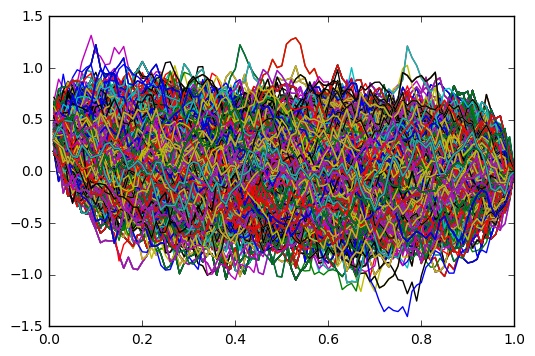

In [162]:
_ = plt.plot(tout.T,samples.T)